In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch , label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    print(image_batch[0].numpy())

(32, 256, 256, 3)
[0 0 2 1 0 1 0 0 0 1 0 0 0 0 2 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0]
[[[163. 166. 185.]
  [182. 185. 204.]
  [167. 170. 189.]
  ...
  [116. 113. 132.]
  [136. 133. 152.]
  [111. 108. 127.]]

 [[154. 157. 176.]
  [137. 140. 159.]
  [157. 160. 179.]
  ...
  [159. 156. 175.]
  [147. 144. 163.]
  [122. 119. 138.]]

 [[139. 142. 161.]
  [139. 142. 161.]
  [164. 167. 186.]
  ...
  [117. 114. 133.]
  [109. 106. 125.]
  [116. 113. 132.]]

 ...

 [[174. 178. 189.]
  [168. 172. 183.]
  [185. 189. 200.]
  ...
  [120. 122. 135.]
  [120. 122. 135.]
  [136. 138. 151.]]

 [[167. 171. 182.]
  [197. 201. 212.]
  [227. 231. 242.]
  ...
  [122. 124. 137.]
  [126. 128. 141.]
  [145. 147. 160.]]

 [[182. 186. 197.]
  [202. 206. 217.]
  [169. 173. 184.]
  ...
  [110. 112. 125.]
  [151. 153. 166.]
  [ 94.  96. 109.]]]


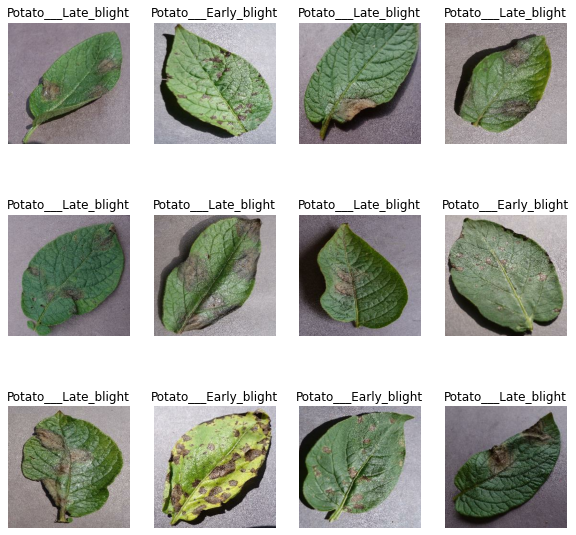

In [7]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_DS = dataset.take(54)
len(train_DS)

54

In [10]:
test_DS = dataset.skip(54)
len(test_DS)

14

In [11]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_DS = test_DS.take(6)
len(val_DS)

6

In [13]:
test_DS_ = test_DS.skip(6)
len(test_DS_)

8

In [14]:
def get_dataset_partitions_df(ds,train_split = 0.8, val_split = 0.1, test_split=0.1, shuffle = True, shuffle_size = 1000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_df(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    
])

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [24]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ["accuracy"]
)

In [25]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds

)

Epoch 1/5
54/54 [==============================] - 92s 2s/step - loss: 0.9202 - accuracy: 0.4942 - val_loss: 0.8515 - val_accuracy: 0.4948
Epoch 2/5
54/54 [==============================] - 89s 2s/step - loss: 0.7147 - accuracy: 0.6852 - val_loss: 0.5086 - val_accuracy: 0.7865
Epoch 3/5
54/54 [==============================] - 92s 2s/step - loss: 0.4239 - accuracy: 0.8356 - val_loss: 0.5964 - val_accuracy: 0.7708
Epoch 4/5
54/54 [==============================] - 94s 2s/step - loss: 0.2997 - accuracy: 0.8825 - val_loss: 0.1951 - val_accuracy: 0.9271
Epoch 5/5
54/54 [==============================] - 93s 2s/step - loss: 0.1910 - accuracy: 0.9225 - val_loss: 0.1196 - val_accuracy: 0.9583


In [26]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 487ms/step - loss: 0.1196 - accuracy: 0.9648


In [27]:
scores

[0.11962717771530151, 0.96484375]

In [28]:
history

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
len(history.history["accuracy"])

5

In [31]:
history.history["accuracy"]

[0.49421295523643494,
 0.6851851940155029,
 0.8356481194496155,
 0.8825231194496155,
 0.9224537014961243]

In [32]:
history.history["val_accuracy"]

[0.4947916567325592,
 0.7864583134651184,
 0.7708333134651184,
 0.9270833134651184,
 0.9583333134651184]

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

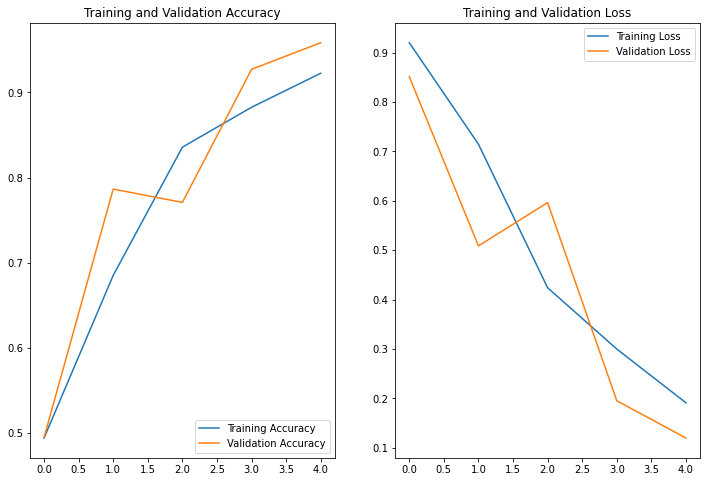

In [34]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


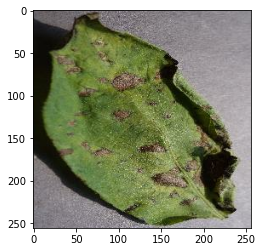

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

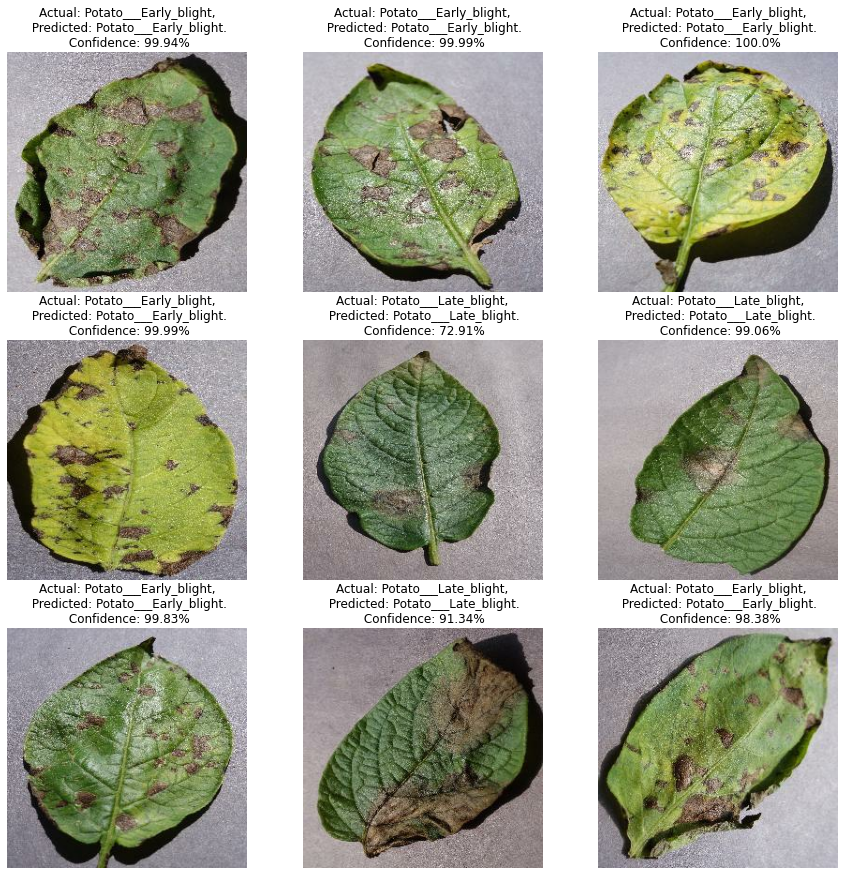

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [38]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


In [39]:
os.listdir("../models")

['1']